# MRI Visualization

This notebook is intended for plotting grids of MRI-images for visualizing the Gonzo dataset. It starts with developing a few tools that make it easier to build multi-axis images and nice visualizations of MRI-data.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import nibabel.nifti1 as nifti1
import skimage
import simple_mri as sm

from gmri2fem.visualization import *

mpl.rcParams.update({'font.size': 14})

mri_dataset = Path("../mri_dataset/")
mri_processed_data = Path("../mri_processed_data/")
subject = "sub-01"
sessions = [f"ses-{idx+1:02d}" for idx in range(5)]

def flatten(list_of_lists):
    return sum(list_of_lists, start=[])


intracranial_mask_mri = sm.load_mri(
    mri_processed_data / f"{subject}/segmentations/{subject}_seg-intracranial_binary.nii.gz",
    bool
)
csf_mask_mri = sm.load_mri(
    mri_processed_data / f"{subject}/segmentations/{subject}_seg-csf_binary.nii.gz",
    bool
)

### Look-Locker IR Sequence

In [2]:
## Look-Locker IR Images
ses = "01"
slice_ = ("sagittal", 90)
orientation = slice_[0]
ll_path = mri_dataset / f"sub-01/ses-{ses}/anat/sub-01_ses-{ses}_acq-looklocker_IRT1.nii.gz"
nii = nifti1.load(ll_path)

# Move time-dimension to first index, for easier indexing
volumes = nii.get_fdata().transpose(-1, 0, 1, 2)

# Convert ms -> s to prevent overflows in exponential function during curve fit.
t_data = np.loadtxt(ll_path.with_name(ll_path.name.split(".")[0] + "_trigger_times.txt")) / 1000.0 

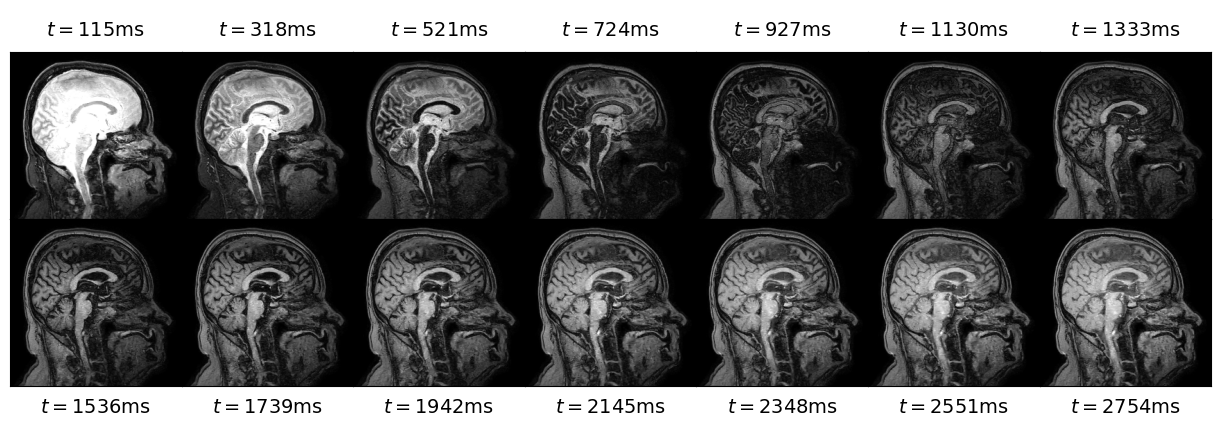

In [3]:
sliced = [slice_volume(volume, *slice_) for volume in volumes]
crop_limits_for_each_volume = np.array(
    [crop_limits(slice_i, 10) for slice_i in sliced]
)
min_row, min_col = crop_limits_for_each_volume.min(axis=0)[::2]
max_row, max_col = crop_limits_for_each_volume.max(axis=0)[1::2]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]

grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.,
    "fig_bottom_margin": 0.,
    "fig_left_margin": 0.,
    "fig_right_margin": 0.0,
    "col_top_margin": 0.1,
    "col_bottom_margin": 0.1,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
    "nrows": 2,
    "ncols": 7,
}

image_grid = [
    [im for im in images[:len(images)//2]],
    [im for im in images[len(images)//2:]]
]

fig, axes = build_image_grid(image_grid, grid_config, False)
axes["body"] = flatten(axes["body"])
vmin = 0
vmax = np.quantile(np.array(images)[:, images[0] > 0], 0.99)
cmap = mpl.cm.gray
for idx, (im, ax) in enumerate(zip(images, axes["body"])):
    ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])

for ti, ax in zip(t_data[:7], axes["col_top"]):
    ax.text(0.5, 0.5, f"$t={int(ti * 1000)}$ms", horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)
for ti, ax in zip(t_data[7:], axes["col_bottom"]):
    ax.text(0.5, 0.5, f"$t={int(ti * 1000)}$ms", horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

plt.savefig(f"../figures/LL-original-{orientation}.pdf")
plt.show()

## Pre-contrast Anatomical Images

In [4]:
slice_ = ("sagittal", 184)
paths = [
    f"../mri_processed_data/{subject}/registered/{subject}_ses-01_{seq}_registered.nii.gz"
    for seq in ["T1w", "T2w", "FLAIR"]
]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
volumes = np.array([mri.data for mri in mris])
# volumes[volumes == 0] = np.nan
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im for im in sliced]


grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.05,
    "fig_left_margin": 0.,
    "fig_right_margin": 0.,
    "col_top_margin": 0.1,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}

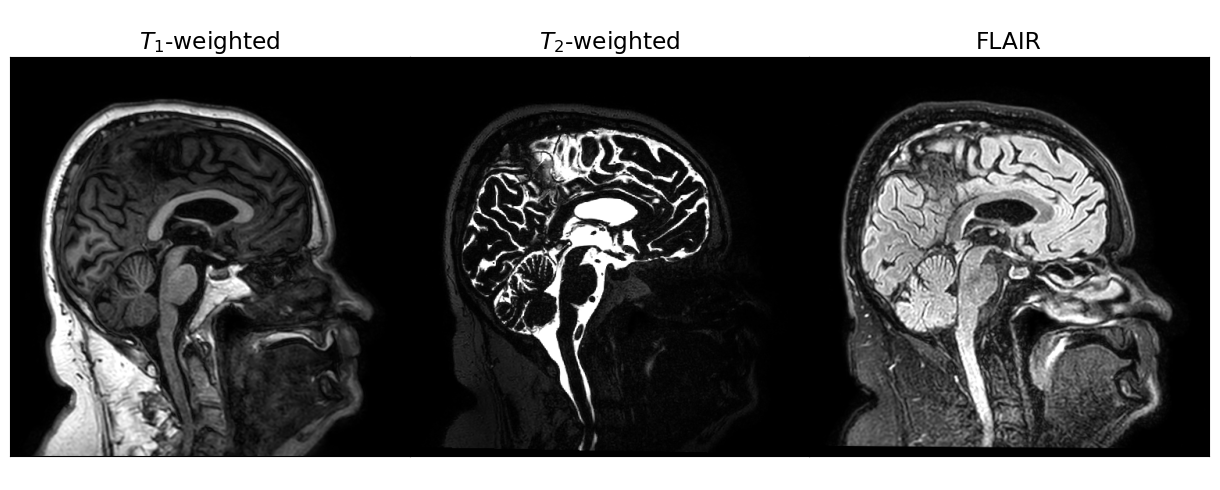

In [5]:
fig_width = 12
fig, axes = build_image_grid([images], grid_config, False)
axes["body"] = flatten(axes["body"])

vmin = 0
vmax = [np.quantile(im[im > 0], cutoff) for im, cutoff in zip(images, (0.99, 0.95, 0.99))]
cmap = mpl.cm.gray
sequence_labels = [r"$T_1$-weighted", r"$T_2$-weighted", "FLAIR"]
for idx, (im, ax) in enumerate(zip(images, axes["body"])):
    ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax[idx])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sequence_labels[idx])
orientation = slice_[0]
plt.savefig(f"../figures/anatomical-{orientation}.pdf")
plt.show()

## $T_1$-weighted

In [6]:
slice_ = ("sagittal", 184)
paths = [f'../mri_processed_data/sub-01/T1w_normalized/sub-01_{ses}_T1w_normalized.nii.gz' for ses in sessions]
paths = [f'../mri_processed_data/sub-01/registered/sub-01_{ses}_T1w_registered.nii.gz' for ses in sessions]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
sliced = [slice_volume(mri.data, *slice_) for mri in mris]
crop_limits_for_each_volume = np.array(
    [crop_limits(im, 10) for im in sliced]
)
min_row, min_col = crop_limits_for_each_volume.min(axis=0)[::2]
max_row, max_col = crop_limits_for_each_volume.max(axis=0)[1::2]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]
ref = images[0]
timestamps = ["Pre-contrast", "4h", "24h", "48h", "70h"]

grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.05,
    "fig_left_margin": 0.,
    "fig_right_margin": 0.,
    "col_top_margin": 0.1,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}

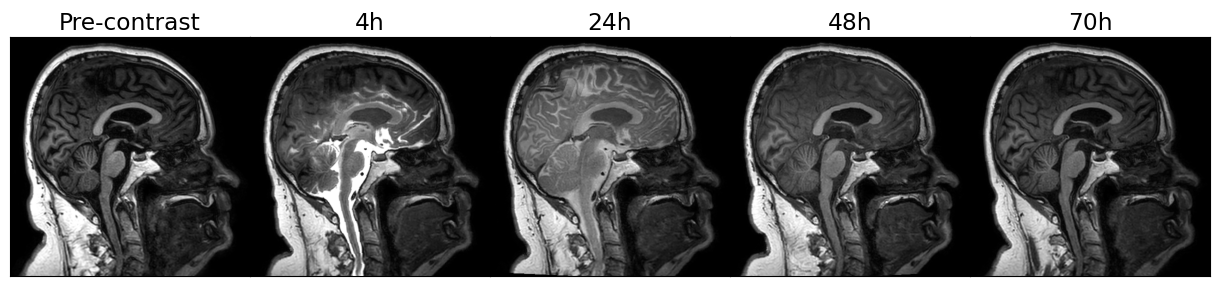

In [7]:
fig_width = 12
fig, axes = build_image_grid([images], grid_config, False)
axes["body"] = flatten(axes["body"])

vmin = 0
vmax = np.quantile(np.array(images)[:, images[0] > 0], 0.99)
cmap = mpl.cm.gray
for idx, (im, ax) in enumerate(zip(images, axes["body"])):
    ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(timestamps[idx])


orientation = slice_[0]
plt.savefig(f"../figures/T1w-registered-{orientation}.pdf", bbox_inches="tight")
plt.show()

## Look-Locker T1-maps

In [8]:
slice_ = ("sagittal", 184)
paths = [
    f"../mri_processed_data/{subject}/registered/{subject}_{ses}_acq-looklocker_T1map_registered.nii.gz"
    for ses in sessions
]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
volumes = np.array([mri.data for mri in mris])
volumes[volumes == 0] = np.nan
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]

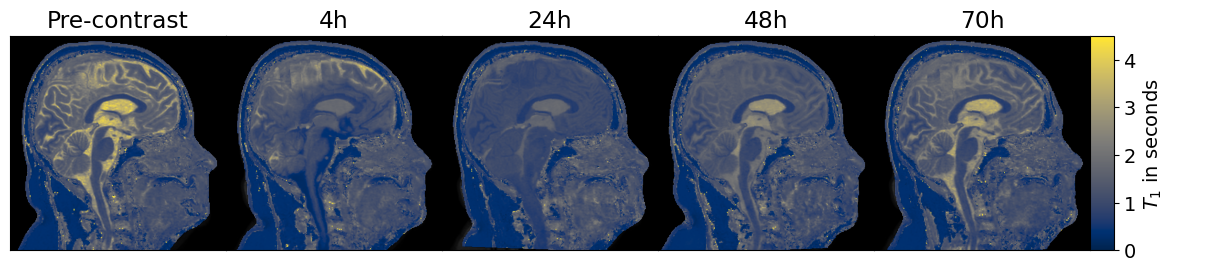

In [9]:
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.05,
    "fig_left_margin": 0.,
    "fig_right_margin": 0.1,
    "col_top_margin": 0.1,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}

fig, axes = build_image_grid([images], grid_config, False)

vmin = 0
vmax = 4500 / 1000
cmap = mpl.cm.cividis
for idx, (im, ax) in enumerate(zip(images, flatten(axes["body"]))):
    ax.imshow(ref, cmap="gray", alpha=0.2)
    ax.imshow(im / 1000, cmap=cmap, vmin=vmin, vmax=vmax )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(timestamps[idx])
    ax.set_facecolor('black')

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
axes["fig_right"].axis("on")
cax_bbox = axes["fig_right"].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="$T_1$ in seconds"
)
plt.savefig(f"../figures/LL-T1map-{orientation}.pdf")
plt.show()

## Mixed T1maps

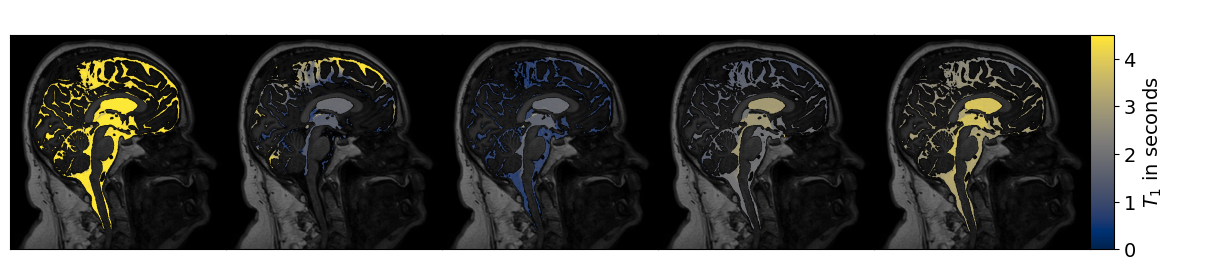

In [10]:
slice_ = ("sagittal", 184)
paths = [
    f"../mri_processed_data/{subject}/registered/{subject}_{ses}_acq-mixed_T1map_registered.nii.gz"
    for ses in sessions
]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
volumes = np.array([mri.data for mri in mris])
volumes[volumes == 0] = np.nan
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]


vmin = 0
vmax = 4500 / 1000
cmap = mpl.cm.cividis
fig, axes = build_image_grid([images], grid_config, False)
for idx, (im, ax) in enumerate(zip(images, flatten(axes["body"]))):
    ax.imshow(ref, cmap="gray", alpha=0.5)
    ax.imshow(im / 1000, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
axes["fig_right"].axis("on")
cax_bbox = axes["fig_right"].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="$T_1$ in seconds"
)

plt.savefig(f"../figures/mixed-T1map-{orientation}.pdf")
plt.show()

## Hybrid T1-maps

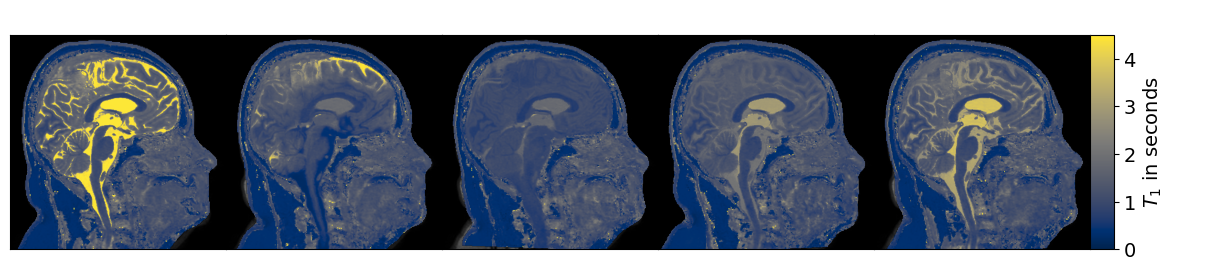

In [11]:
paths = [
    f"../mri_processed_data/{subject}/T1maps/{subject}_{ses}_T1map_hybrid.nii.gz"
    for ses in sessions
]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
volumes = np.array([mri.data for mri in mris])
volumes[volumes == 0] = np.nan
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]


vmin = 0
vmax = 4500 / 1000
cmap = mpl.cm.cividis
fig, axes = build_image_grid([images], grid_config, False)
for idx, (im, ax) in enumerate(zip(images, flatten(axes["body"]))):
    ax.imshow(ref, cmap="gray", alpha=0.5)
    ax.imshow(im / 1000, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
axes["fig_right"].axis("on")
cax_bbox = axes["fig_right"].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="$T_1$ in seconds"
)

plt.savefig(f"../figures/hybrid-T1map-{orientation}.pdf")
plt.show()

## Concentrations

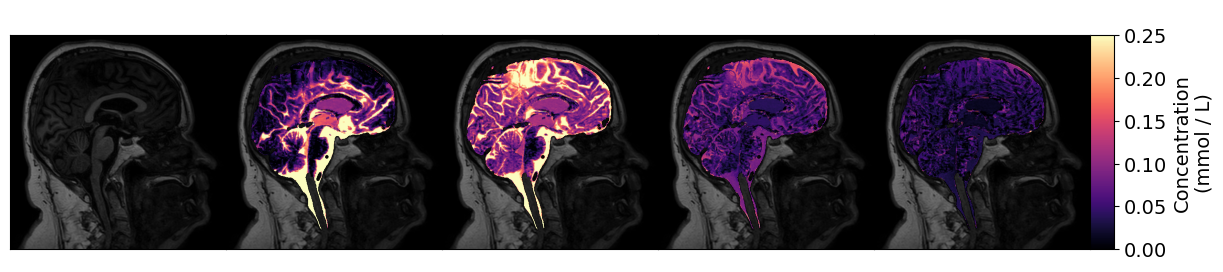

In [12]:
paths = [
    f"../mri_processed_data/{subject}/concentrations/{subject}_{ses}_concentration.nii.gz"
    for ses in sessions
]
mris = [sm.load_mri(p, dtype=np.single) for p in paths]
volumes = np.array([mri.data for mri in mris])
volumes[volumes == 0] = np.nan
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]


cmin = 0
cmax = 0.25
cmap = mpl.cm.cividis
fig, axes = build_image_grid([images], grid_config, False)
for idx, (im, ax) in enumerate(zip(images, flatten(axes["body"]))):
    ax.imshow(ref, cmap="gray", alpha=0.5)
    ax.imshow(im, cmap=mpl.cm.magma, vmin=cmin, vmax=cmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
axes["fig_right"].axis("on")
cax_bbox = axes["fig_right"].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma),
    cax=cax,
    orientation='vertical',
    label="Concentration\n(mmol / L)"
)

plt.savefig(f"../figures/concentrations-{orientation}.pdf")
plt.show()

# T1-map Stack

In [13]:
T1map_paths = [
    [f"../mri_processed_data/{subject}/registered/{subject}_{ses}_acq-looklocker_T1map_registered.nii.gz" for ses in sessions],
    [f"../mri_processed_data/{subject}/registered/{subject}_{ses}_acq-mixed_T1map_registered.nii.gz"for ses in sessions],
    [f"../mri_processed_data/{subject}/T1maps/{subject}_{ses}_T1map_hybrid.nii.gz" for ses in sessions],
    [f"../mri_processed_data/{subject}/concentrations/{subject}_{ses}_concentration.nii.gz" for ses in sessions]
]

images = []
for idx, pathlist in enumerate(T1map_paths):
    nii = [sm.load_mri(p, dtype=np.single) for  p in pathlist]
    volumes = np.array([nii_i.data for nii_i in nii])
    if idx < 3:
        volumes[volumes < 0.1] = np.nan
        volumes[:, ~(intracranial_mask_mri.data)] = np.nan
    sliced = np.array([
        slice_volume(volume, *slice_)
        for volume in volumes
    ])
    images.append([im[min_row:max_row, min_col:max_col] for im in sliced])

In [14]:
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.02,
    "fig_left_margin": 0.,
    "fig_right_margin": 0.1,
    "col_top_margin": 0.05,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.05,
    "row_right_margin": 0.1,
}

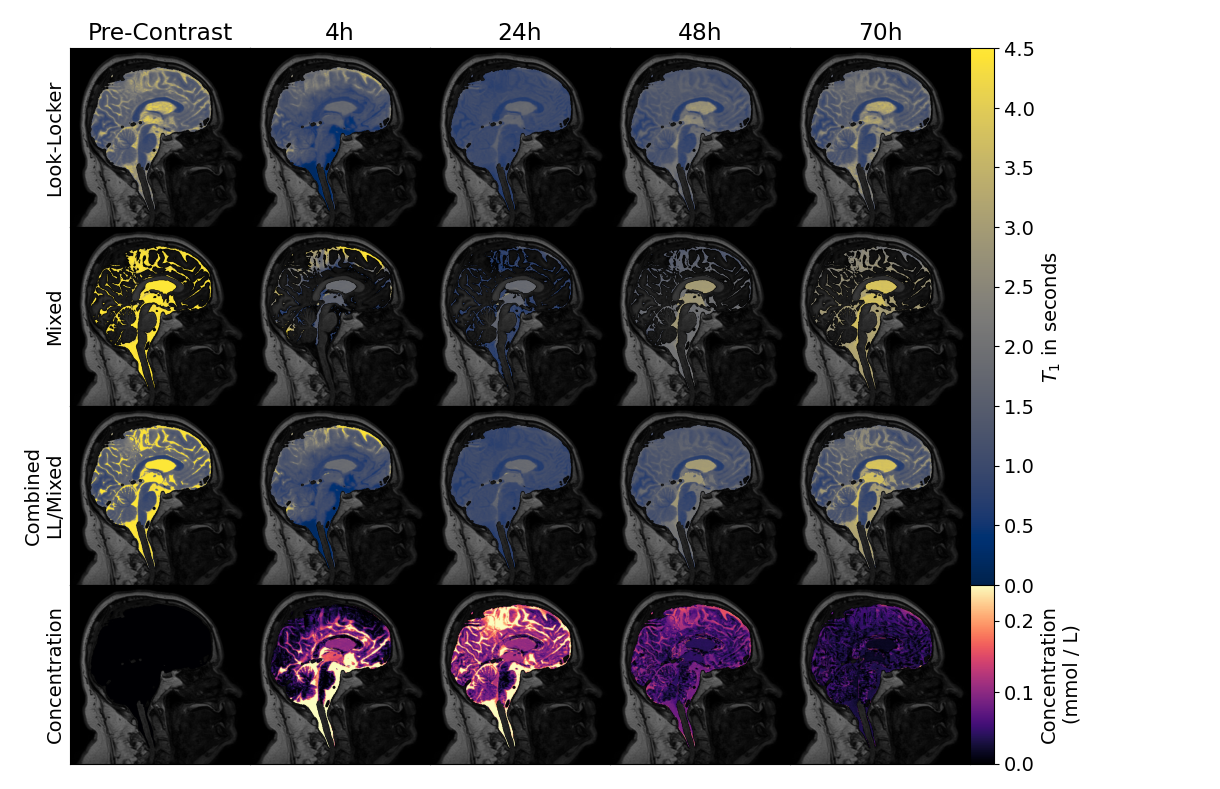

In [15]:
fig, axes = build_image_grid(images, grid_config, False)
axes["body"] = flatten(axes["body"])
cmap = mpl.cm.cividis
for idx, (im, ax) in enumerate(zip(flatten(images[:3]), axes["body"])):
    ax.imshow(ref, cmap="gray", alpha=0.5)
    ax.imshow(im / 1000, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')


norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
axes["fig_right"].axis("on")
cax_bbox = axes["row_right"][-2].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height * 3,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label=r"$T_1$ in seconds"
)

for idx, (im, ax) in enumerate(zip(images[-1], axes["body"][-5:])):
    ax.imshow(ref, cmap="gray", alpha=0.5)
    ax.imshow(im, cmap=mpl.cm.magma, vmin=0, vmax=0.25)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

    
cax_bbox = axes["row_right"][-1].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
) 
cnorm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=cnorm, cmap=mpl.cm.magma),
    cax=cax,
    orientation='vertical',
    label="Concentration\n(mmol / L)"
)
    
for label, ax in zip(("Look-Locker", "Mixed", "Combined\nLL/Mixed", "Concentration"), axes["body"][::5]):
    ax.set_ylabel(label)
    
for label, ax in zip(("Pre-Contrast", "4h", "24h", "48h", "70h"), axes["body"][:5]):
    ax.set_title(label)
plt.savefig(f"../figures/T1maps-panel-{orientation}.pdf")
plt.show()

## DTI

In [16]:
slice_ = ("axial", 315)

# Load T1w-background image
ref_path = f"../mri_processed_data/{subject}/registered/{subject}_ses-01_T1w_registered.nii.gz"
ref_nii = sm.load_mri(ref_path, dtype=np.single)
ref_sliced = slice_volume(ref_nii.data, *slice_)
ref_crop_limits = crop_limits(ref_sliced, 10)
min_row, min_col = ref_crop_limits[::2]
max_row, max_col = ref_crop_limits[1::2]
im_ref = ref_sliced[min_row:max_row, min_col:max_col]

# Load DTI-data
md = sm.load_mri(f"../mri_processed_data/{subject}/registered/{subject}_ses-01_dDTI_MD_registered.nii.gz", dtype=np.single)
fa = sm.load_mri(f"../mri_processed_data/{subject}/registered/{subject}_ses-01_dDTI_FA_registered.nii.gz", dtype=np.single)
v1 = sm.load_mri(f"../mri_processed_data/{subject}/registered/{subject}_ses-01_dDTI_V1_registered.nii.gz", dtype=np.single)        
volumes = [mri.data for mri in [md, v1, fa]]

# Mask non-brain tissueS
for volume in volumes:
    volume[(~intracranial_mask_mri.data) + csf_mask_mri.data] *= np.nan 

# Slice and crop images, comute color-coded FA
sliced = [slice_volume(volume, *slice_) for volume in volumes]
images = [im[min_row:max_row, min_col:max_col] for im in sliced]
images[-2] = images[-1][..., np.newaxis] * np.abs(images[-2]) # Color-coded FA

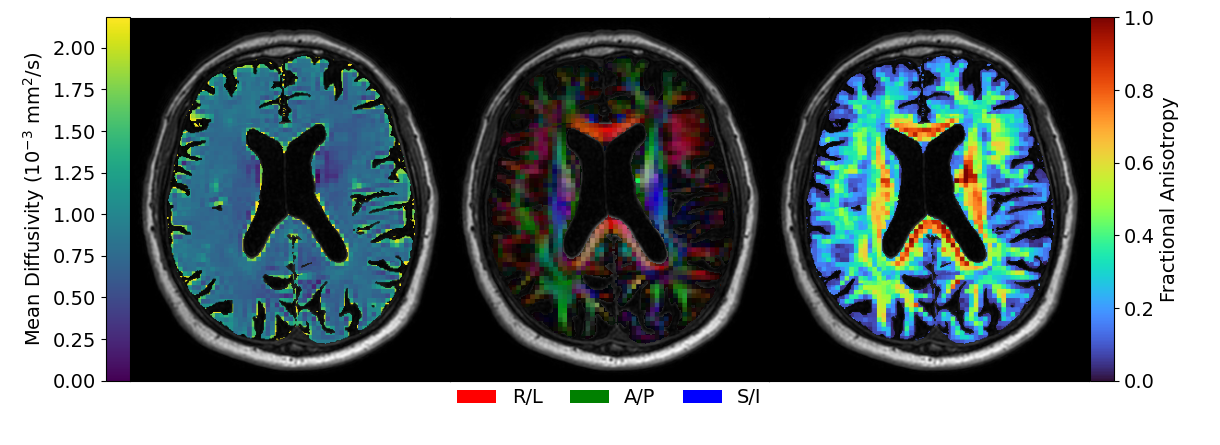

In [17]:
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.03,
    "fig_left_margin": 0.0,
    "fig_right_margin": 0.0,
    "col_top_margin": 0.0,
    "col_bottom_margin": 0.1,
    "row_left_margin": 0.1,
    "row_right_margin": 0.1,
}

### MD ###
cmap = mpl.cm.viridis
im = images[0]

fig_width = 12
fig, axes = build_image_grid([images], grid_config, False)
axes["body"] = flatten(axes["body"])
md_cmap = mpl.cm.viridis
ax = axes["body"][0]
im = images[0]
vmin = np.nanquantile(im, 0.01)
vmax = np.nanquantile(im, 0.99) * 1000
ax.imshow(im_ref, cmap="gray")
ax.imshow(im * 1000, cmap=cmap, vmin=0, vmax=vmax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("black")

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cax_bbox = axes["row_left"][0].get_position()
cax_width = 0.2
cax = fig.add_axes(
    [
        cax_bbox.x0 + (1 - cax_width) * cax_bbox.width,
        cax_bbox.y0,
        cax_width*cax_bbox.width,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
)
cbar.ax.yaxis.set_ticks_position('left')  # Move ticks to the left
cbar.ax.yaxis.set_label_position('left')  # Move label to the left
cax.set_ylabel("Mean Diffusivity ($10^{-3}$ mm$^2$/s)")

### Directional FA ### 
im = images[1]
ax = axes["body"][1]
ax.imshow(im_ref, cmap="gray")
ax.imshow(im)
ax.set_facecolor("black")

legend_elements = [
    mpl.patches.Patch(facecolor='red', label='R/L'),
    mpl.patches.Patch(facecolor='green', label='A/P'),
    mpl.patches.Patch(facecolor='blue', label='S/I'),
]
ax.legend(
    handles=legend_elements,
    bbox_to_anchor=(0., -0.1, 1., .1),
    loc='upper left',
    ncols=3,
    mode="expand",
    frameon=False,
    borderaxespad=0.,
)


### FA ###
ax = axes["body"][2]
im = images[2]
cmap = mpl.cm.turbo

ax.imshow(im_ref, cmap="gray")
ax.imshow(im, cmap=cmap, vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("black")

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax_bbox = axes["row_right"][0].get_position()
cax = fig.add_axes(
    [
        cax_bbox.x0,#+ 0.5 * cax_bbox.width,
        cax_bbox.y0, #+ 0.5 * cax_bbox.height,
        0.2*cax_bbox.width,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
)
cbar.ax.yaxis.set_ticks_position('right')  # Move ticks to the left
cbar.ax.yaxis.set_label_position('right')  # Move label to the left
cax.set_ylabel("Fractional Anisotropy")

plt.savefig(f"../figures/DTI.pdf", bbox_inches="tight")
plt.show()